In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import os

Using TensorFlow backend.


In [2]:
mainDir = os.listdir('D:/chest_xray')
#train_normal = 'D:/chest_xray/train/NORMAL'
#train_pneumonia = 'D:/chest_xray/train/PNEUMONIA'

In [3]:
mainDir

['chest_xray', 'test', 'train', 'val', '__MACOSX']

In [4]:
IMAGE_SIZE = [224, 224]

train_folder =  'D:/chest_xray/train/'
test_folder = 'D:/chest_xray/test/'
val_folder = 'D:/chest_xray/val/'

In [5]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [6]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [7]:
folders = glob('D:/chest_xray/train/*')

In [8]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('D:/chest_xray/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [14]:

test_set = test_datagen.flow_from_directory('D:/chest_xray/test/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


import pandas as pd

training_set = pd.DataFrame(training_set)

training_set

In [15]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=20
)


Epoch 1/5
163/163 [==============================] - 1290s 8s/step - loss: 0.2173 - accuracy: 0.9187 - val_loss: 0.9112 - val_accuracy: 0.8878
Epoch 2/5
163/163 [==============================] - 1415s 9s/step - loss: 0.1095 - accuracy: 0.9599 - val_loss: 0.2245 - val_accuracy: 0.8686
Epoch 3/5
163/163 [==============================] - 1239s 8s/step - loss: 0.1007 - accuracy: 0.9643 - val_loss: 0.0452 - val_accuracy: 0.9071
Epoch 4/5
163/163 [==============================] - 1308s 8s/step - loss: 0.0759 - accuracy: 0.9714 - val_loss: 0.0929 - val_accuracy: 0.9247
Epoch 5/5
163/163 [==============================] - 1342s 8s/step - loss: 0.0726 - accuracy: 0.9751 - val_loss: 0.7135 - val_accuracy: 0.9022


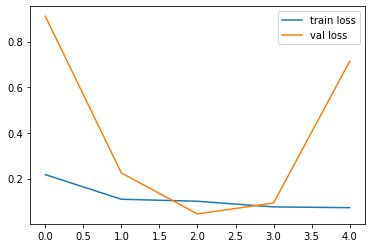

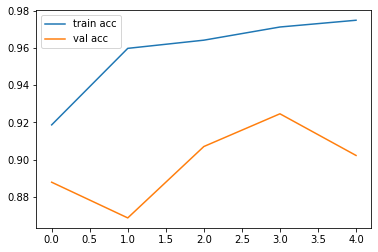

<Figure size 432x288 with 0 Axes>

In [18]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [19]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

model.save('model_vgg16.h5')

In [25]:
import pandas as pd 

p = model.predict_generator(test_set)

pre = pd.DataFrame(p)

pre["filename"] = test_set.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)

In [28]:
pre['pre'] = (pre[1]>0.5).apply(int)
pre

,0,1,filename,label,pre
0,9.607151e-01,0.039285,NORMAL\IM-0001-0001.jpeg,0,0
1,9.931658e-01,0.006834,NORMAL\IM-0003-0001.jpeg,0,0
2,5.996703e-07,0.999999,NORMAL\IM-0005-0001.jpeg,0,1
3,8.692001e-01,0.130800,NORMAL\IM-0006-0001.jpeg,0,0
4,9.785691e-01,0.021431,NORMAL\IM-0007-0001.jpeg,0,0
...,...,...,...,...,...
619,3.008479e-05,0.999970,PNEUMONIA\person96_bacteria_465.jpeg,1,1
620,9.985998e-01,0.001400,PNEUMONIA\person96_bacteria_466.jpeg,1,0
621,1.008286e-05,0.999990,PNEUMONIA\person97_bacteria_468.jpeg,1,1
622,9.963136e-01,0.003686,PNEUMONIA\person99_bacteria_473.jpeg,1,0


In [29]:
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score

recall_score(pre["label"],pre["pre"]) 

0.6948717948717948